# Loading Data

In [1]:
import torch
import os

DATA_ROOT_DIR = '../../datasets/ecg/gwbz3fsgp8-2/'

The dataset has this structure:
```bash
.
├── ECG Images of Myocardial Infarction Patients (240x12=2880)
│   ├── MI(1).jpg
│   ├── (...)
│   └── MI(240).jpg
├── ECG Images of Patient that have History of MI (172x12=2064)
│   ├── PMI(1).jpg
│   ├── (...)
│   └── PMI(172).jpg
├── ECG Images of Patient that have abnormal heartbeat (233x12=2796)
│   ├── HB(1).jpg
│   ├── (...)
│   └── HB(233).jpg
└── Normal Person ECG Images (284x12=3408)
    ├── Normal(1).jpg
    ├── (...)
    └── Normal(284).jpg

4 directories, 928 files
```

## preparing the data for training

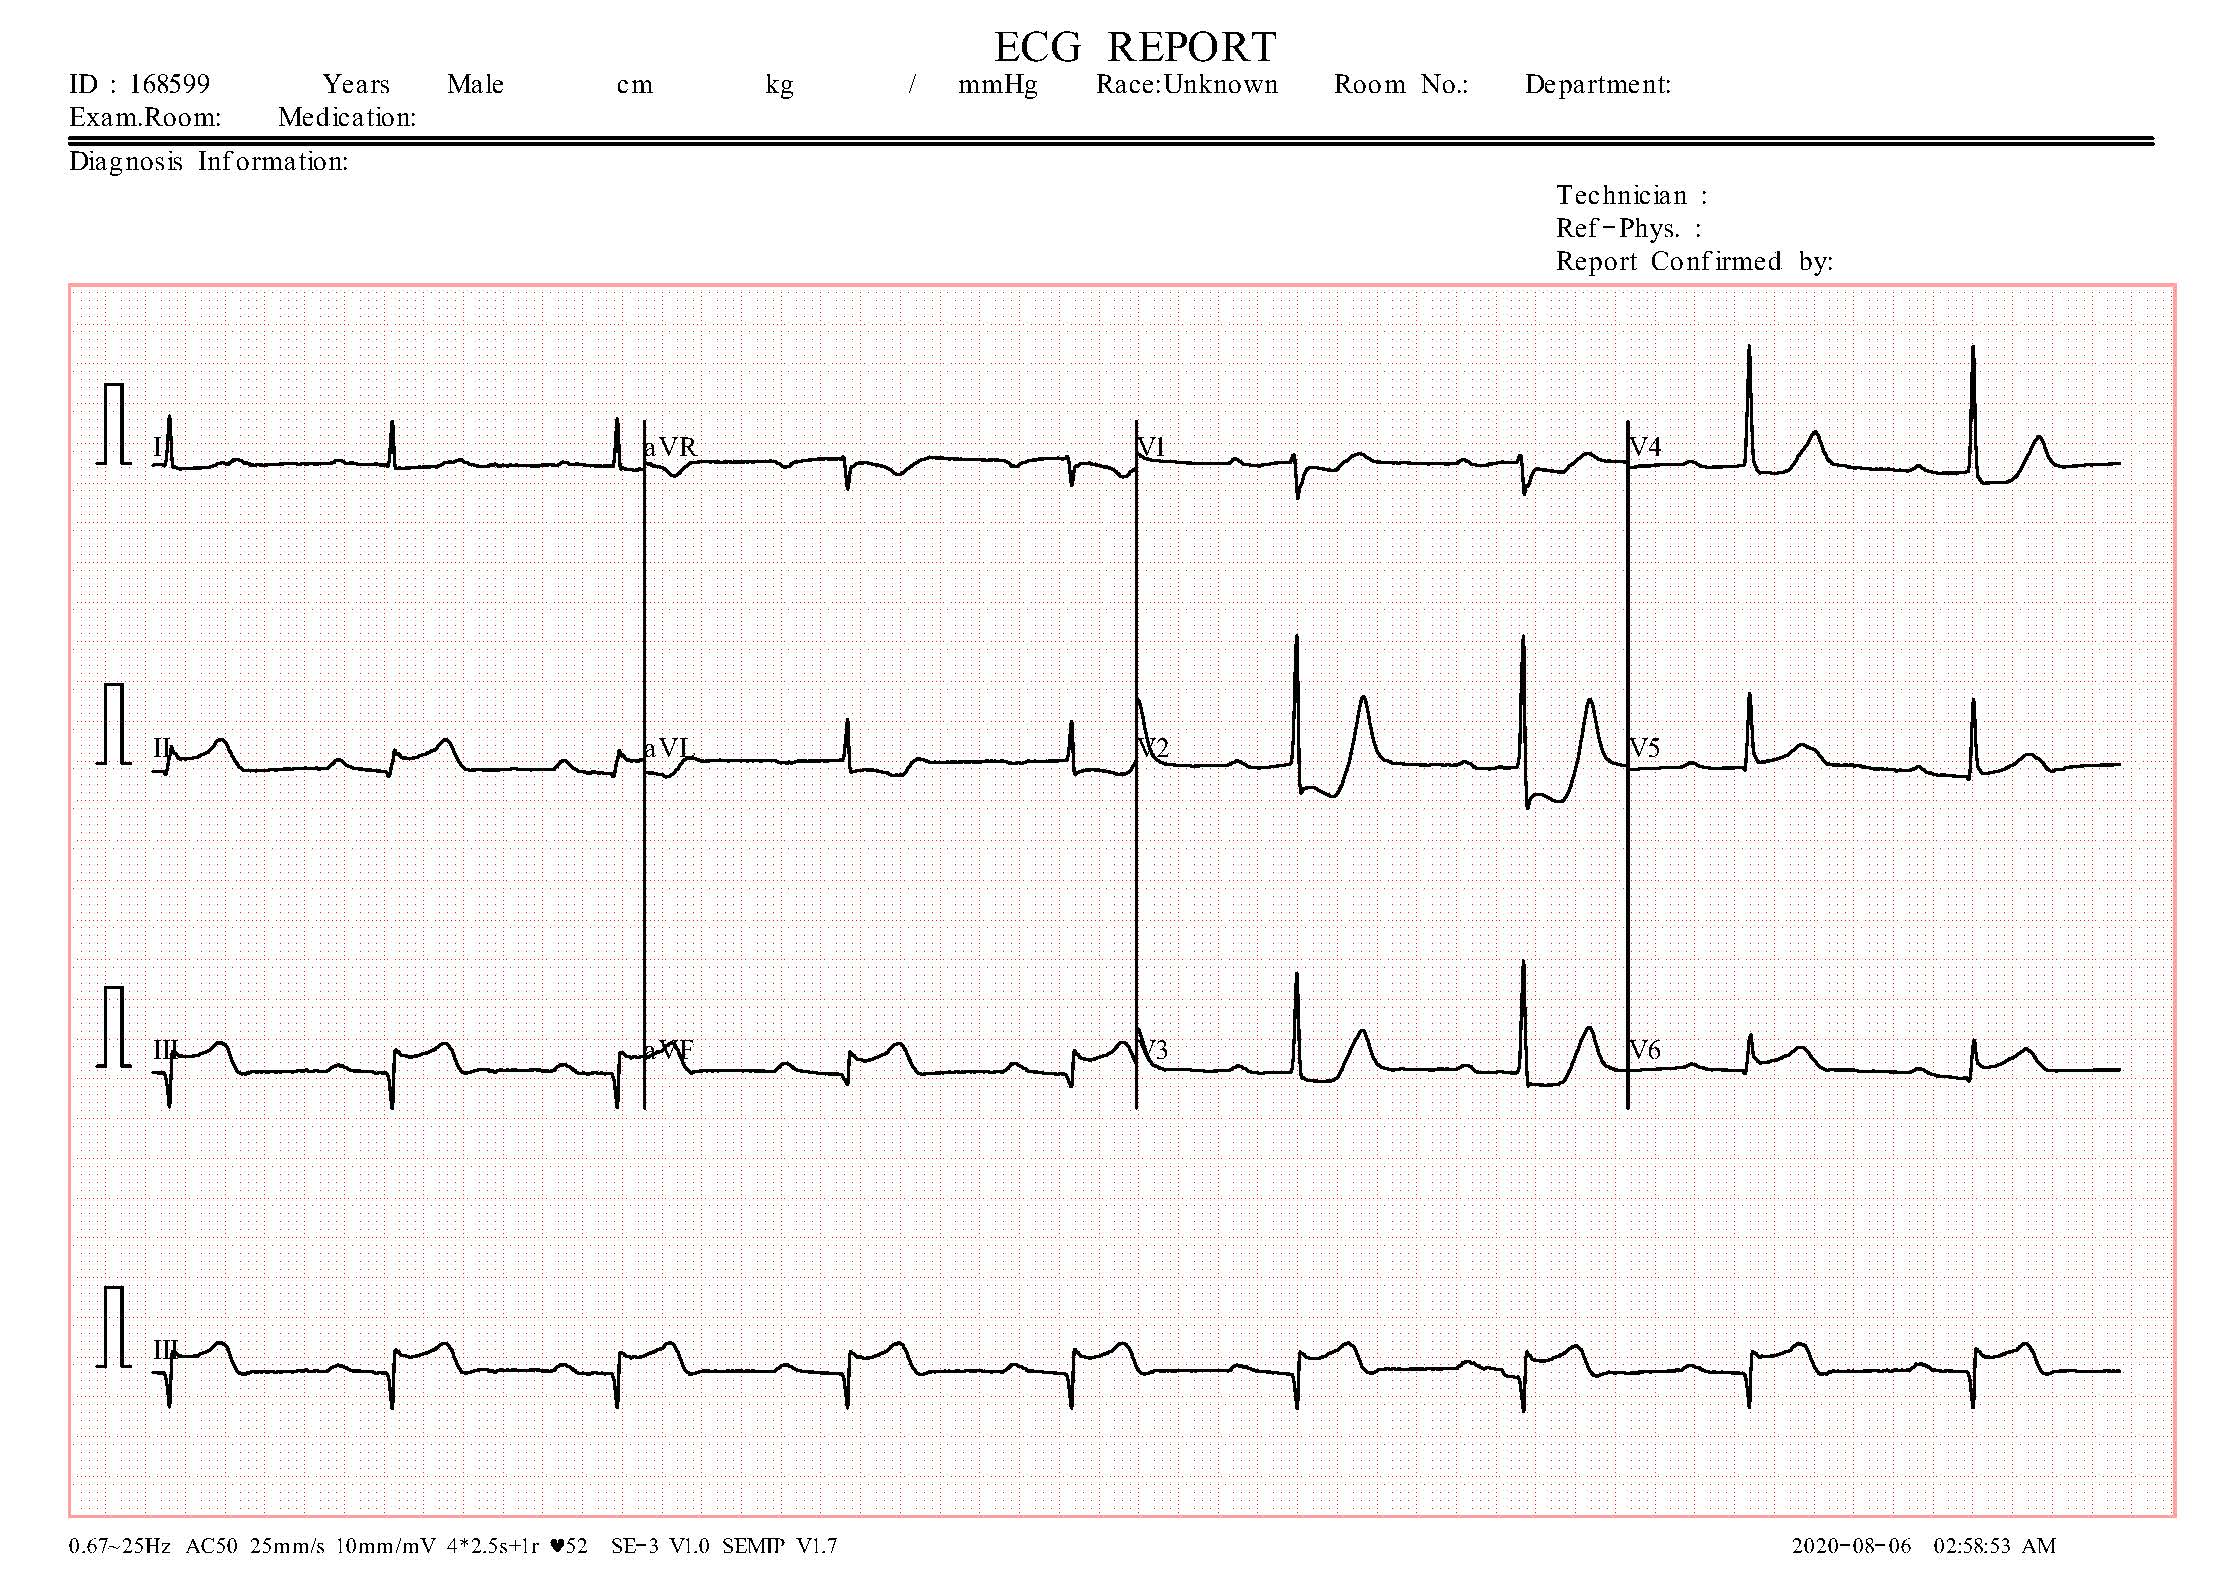

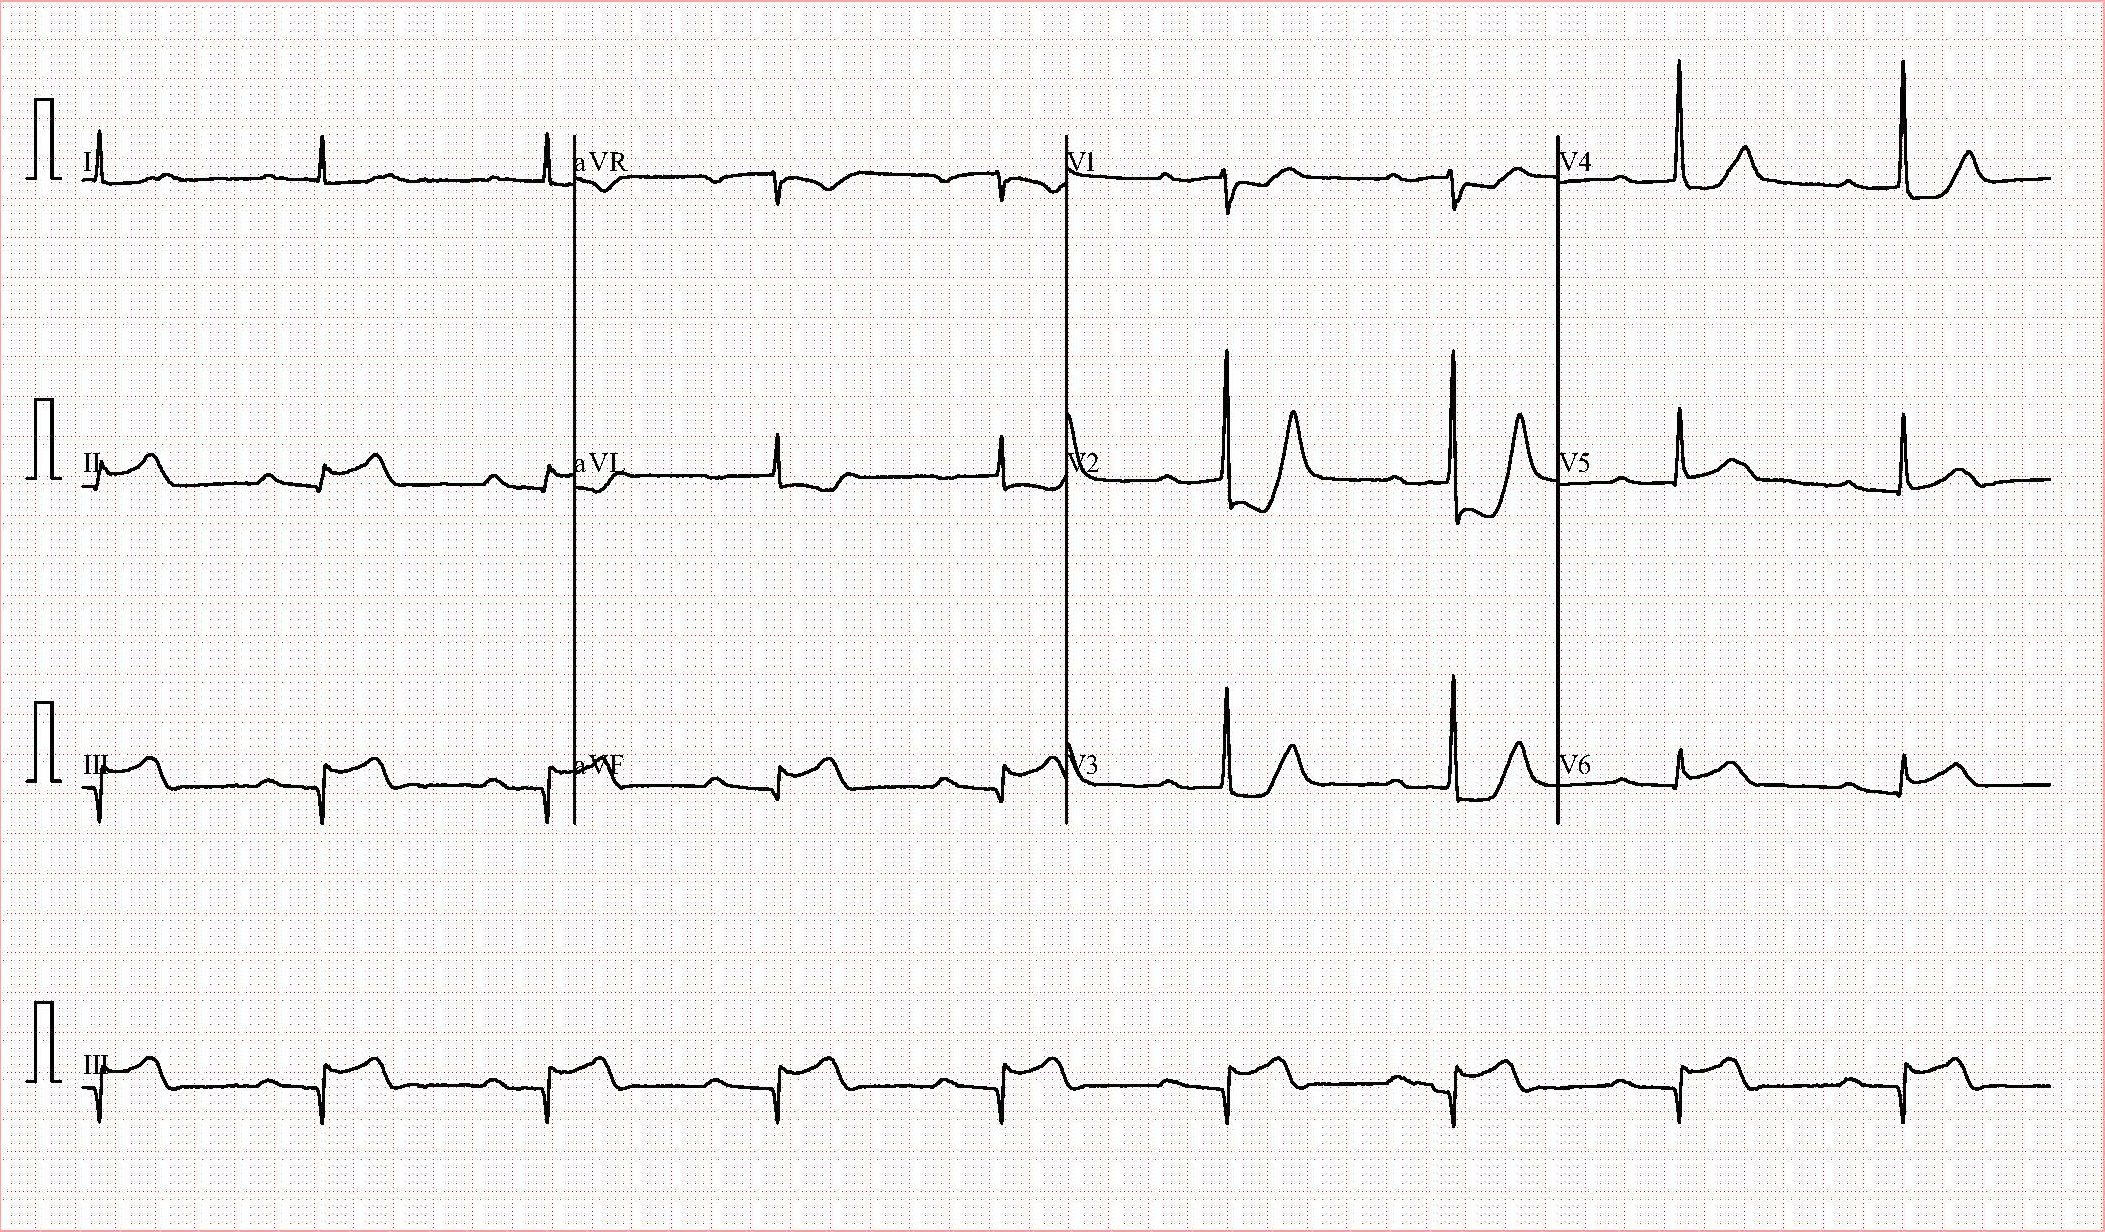

In [2]:
from PIL import Image
from random import randint
from dataset import ECGDataset

# Example usage:
whole_dataset = ECGDataset(root_dir=DATA_ROOT_DIR, crop=None)
whole_dataset_cropped = ECGDataset(root_dir=DATA_ROOT_DIR, crop=(70,285,2175,1517))
idx = randint(0, len(whole_dataset_cropped) - 1)
img, label_id = whole_dataset[idx]
display(img)
img2, label_id = whole_dataset_cropped[idx]
display(img2)

dividindo a base em treino, validação e teste (80%, 10%, 10%) de forma estratificada, ou seja, mantendo a proporção de classes em cada conjunto...

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

# Split the dataset into train (80%) and test+val (20%)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, testval_index = next(sss.split(whole_dataset.labels, whole_dataset.labels))
train_dataset = torch.utils.data.Subset(whole_dataset, train_index)
testval_dataset = torch.utils.data.Subset(whole_dataset, testval_index)

# Split the test+val set into validation (10%) and test (10%)
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
testval_labels = [whole_dataset.labels[i] for i in testval_index]
val_index, test_index = next(sss_val.split(testval_labels, testval_labels))
val_dataset = torch.utils.data.Subset(whole_dataset, [testval_index[i] for i in val_index])
test_dataset = torch.utils.data.Subset(whole_dataset, [testval_index[i] for i in test_index])

print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

Train dataset size: 742
Validation dataset size: 93
Test dataset size: 93


Definindo as transformações para os dados de treino, validação e teste:

In [4]:
import albumentations as A

train_transform = A.Compose([
    A.Resize(224, 224),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # ImageNet stats
    A.pytorch.ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # ImageNet stats
    A.pytorch.ToTensorV2()
])

In [5]:
# addicionar as transformações aos datasets
from dataset import DatasetWithTransform
# NOTA: não rode esta célula mais de uma vez, senão as transformações serão empilhadas
# aplicando as transformações
train_dataset = DatasetWithTransform(train_dataset, train_transform)
val_dataset = DatasetWithTransform(val_dataset, val_test_transform)
test_dataset = DatasetWithTransform(test_dataset, val_test_transform)

In [6]:
# invert the normalization for visualization
import numpy as np
def inverse_transform(image: np.ndarray) -> Image.Image:
    """Inverse the normalization transform."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inv_image = image * std + mean
    inv_image = np.clip(inv_image, 0, 1)
    return Image.fromarray((inv_image * 255).astype(np.uint8))

torch.Size([3, 224, 224]) 3
tensor(-2.1179) tensor(2.6400) torch.float32 torch.Size([3, 224, 224])


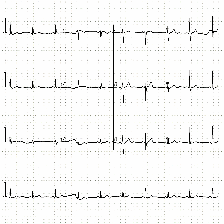

In [7]:
# exemplo de como a imagem fica após a transformação
whole_dataset.crop = (70,285,2175,1517)
img, label = train_dataset[0]
print(img.shape, label)
print(img.min(), img.max(), img.dtype, img.shape)
inverse_transform(img.numpy().transpose(1, 2, 0))

In [8]:
# Defining dataloaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = 8

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Defining the Model

In [9]:
# # Descomente se quiser ver a arquitetura do modelo
# from torchvision.models import resnet18, ResNet18_Weights
# resnet18(weights=ResNet18_Weights.DEFAULT)

In [10]:
from ecgclassifier_model import ECGClassifier

In [11]:
%load_ext tensorboard

In [12]:
model = ECGClassifier(num_classes=4)

In [13]:
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger, WandbLogger
import lightning as L

tlogger = TensorBoardLogger('lightning_logs/', name='ecg_clf')
# wlogger = WandbLogger(project='ecg_tcc_clf', log_model=False)

# log hyperparameters for later reference
params = {
    'learning_rate': model.learning_rate,
    'num_epochs': 20,
    'backbone_name': model.backbone.__class__.__name__,
    'num_classes': model.num_classes,
    'batch_size': BATCH_SIZE,
    'crop': whole_dataset.crop,
    'model_size_millions': sum(p.numel() for p in model.parameters() if p.requires_grad) / 10**6
}
tlogger.log_hyperparams(params)

best_ckpt_callback = ModelCheckpoint(
    monitor='val/accuracy',
    mode='max',
    save_top_k=1,
    filename='ecg-clf-best-epoch={epoch:02d}-acc={val/accuracy:.4f}',
    # Is useful to set auto_insert_metric_name to ``False`` when metric names contain ``/`` as this will result in extra folders.
    auto_insert_metric_name=False
)

trainer = L.Trainer(
    max_epochs=params['num_epochs'],
    accelerator='auto',
    enable_model_summary=True,
    logger=tlogger,
    callbacks=[best_ckpt_callback],
)

trainer.fit(
    model=model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

INFO: GPU available: True (cuda), used: True


[11/14/25 12:36:50] INFO     GPU available: True (cuda), used: True                                    ]8;id=52365;file:///home/lhsmello/projects/medical/ECG-tcc-erika/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py\setup.py]8;;\:]8;id=427417;file:///home/lhsmello/projects/medical/ECG-tcc-erika/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py#156\156]8;;\

INFO: TPU available: False, using: 0 TPU cores


                    INFO     TPU available: False, using: 0 TPU cores                                  ]8;id=719098;file:///home/lhsmello/projects/medical/ECG-tcc-erika/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py\setup.py]8;;\:]8;id=949084;file:///home/lhsmello/projects/medical/ECG-tcc-erika/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py#159\159]8;;\

INFO: HPU available: False, using: 0 HPUs


                    INFO     HPU available: False, using: 0 HPUs                                       ]8;id=248259;file:///home/lhsmello/projects/medical/ECG-tcc-erika/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py\setup.py]8;;\:]8;id=943857;file:///home/lhsmello/projects/medical/ECG-tcc-erika/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py#169\169]8;;\

/home/lhsmello/projects/medical/ECG-tcc-erika/.venv/lib/python3.12/site-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return _C._get_float32_matmul_precision()
INFO: You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_ma

                    INFO     You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor    ]8;id=348017;file:///home/lhsmello/projects/medical/ECG-tcc-erika/.venv/lib/python3.12/site-packages/lightning/fabric/accelerators/cuda.py\cuda.py]8;;\:]8;id=619759;file:///home/lhsmello/projects/medical/ECG-tcc-erika/.venv/lib/python3.12/site-packages/lightning/fabric/accelerators/cuda.py#166\166]8;;\
                             Cores. To properly utilize them, you should set                                       
                             `torch.set_float32_matmul_precision('medium' | 'high')` which will                    
                             trade-off precision for performance. For more details, read                           
                             https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precisi            
                             on.html#torch.set_float32_matmul_precision                                            

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


                    INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]                                   ]8;id=795764;file:///home/lhsmello/projects/medical/ECG-tcc-erika/.venv/lib/python3.12/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=622709;file:///home/lhsmello/projects/medical/ECG-tcc-erika/.venv/lib/python3.12/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\

INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | backbone      | ResNet           | 21.3 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | ModuleDict       | 0      | train
3 | val_metrics   | ModuleDict       | 0      | train
4 | test_metrics  | ModuleDict       | 0      | train
-----------------------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.147    Total estimated model params size (MB)
135       Modules in train mode
0         Modules in eval mode


                    INFO                                                                       ]8;id=10933;file:///home/lhsmello/projects/medical/ECG-tcc-erika/.venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_summary.py\model_summary.py]8;;\:]8;id=930712;file:///home/lhsmello/projects/medical/ECG-tcc-erika/.venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_summary.py#104\104]8;;\
                               | Name          | Type             | Params | Mode                                  
                             -----------------------------------------------------------                           
                             0 | backbone      | ResNet           | 21.3 M | train                                 
                             1 | criterion     | CrossEntropyLoss | 0      | train                                 
                             2 | train_metrics | ModuleDict       | 0      | train                                 
                             3 | val_metrics   | ModuleDict       | 0      | train                                 
                             4 | test_metrics  | ModuleDict       | 0      | train                                 
                             -----------------------------------------------------------                           
                             21.3 M    Trainable params                                                            
                             0         Non-trainable params                                                        
                             21.3 M    Total params                                                                
                             85.147    Total estimated model params size (MB)                                      
                             135       Modules in train mode                                                       
                             0         Modules in eval mode                                                        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/lhsmello/projects/medical/ECG-tcc-erika/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.


[11/14/25 12:38:00] INFO     `Trainer.fit` stopped: `max_epochs=20` reached.                        ]8;id=104607;file:///home/lhsmello/projects/medical/ECG-tcc-erika/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py\fit_loop.py]8;;\:]8;id=581881;file:///home/lhsmello/projects/medical/ECG-tcc-erika/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py#191\191]8;;\

In [14]:
result = trainer.test(
    model=model,
    dataloaders=test_loader
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


                    INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]                                   ]8;id=947702;file:///home/lhsmello/projects/medical/ECG-tcc-erika/.venv/lib/python3.12/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=532696;file:///home/lhsmello/projects/medical/ECG-tcc-erika/.venv/lib/python3.12/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.9462365508079529     │
│       test/f1score        │    0.9370548725128174     │
│         test/loss         │    0.3088573217391968     │
│      test/precision       │    0.9529629945755005     │
│        test/recall        │    0.9307597875595093     │
│     test/specificity      │    0.9818840622901917     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[11/14/25 12:40:16] INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]                                   ]8;id=769259;file:///home/lhsmello/projects/medical/ECG-tcc-erika/.venv/lib/python3.12/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=297033;file:///home/lhsmello/projects/medical/ECG-tcc-erika/.venv/lib/python3.12/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\

Predicting: |          | 0/? [00:00<?, ?it/s]

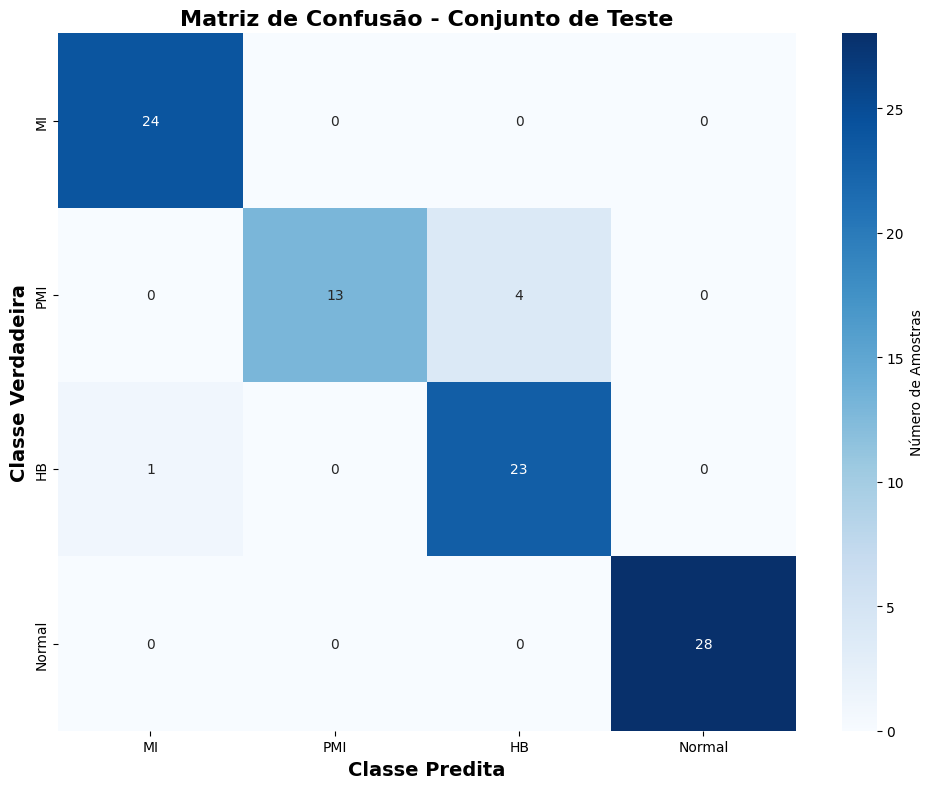


Relatório de Classificação:
              precision    recall  f1-score   support

          MI     0.9600    1.0000    0.9796        24
         PMI     1.0000    0.7647    0.8667        17
          HB     0.8519    0.9583    0.9020        24
      Normal     1.0000    1.0000    1.0000        28

    accuracy                         0.9462        93
   macro avg     0.9530    0.9308    0.9371        93
weighted avg     0.9514    0.9462    0.9451        93



In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os

# Criar diretório se não existir
os.makedirs('../texto/figuras/', exist_ok=True)


# Get predictions
predictions = trainer.predict(model, test_loader)
predicted_labels = torch.concatenate(predictions).numpy()
true_labels = np.concatenate([y for x, y in test_loader])

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
classes = whole_dataset.classes

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Número de Amostras'})
plt.xlabel('Classe Predita', fontsize=14, fontweight='bold')
plt.ylabel('Classe Verdadeira', fontsize=14, fontweight='bold')
plt.title('Matriz de Confusão - Conjunto de Teste', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../texto/figuras/matriz_confusao.png', dpi=300, bbox_inches='tight')
plt.show()

# Calcular e exibir métricas por classe
from sklearn.metrics import classification_report
print("\nRelatório de Classificação:")
print("="*60)
print(classification_report(true_labels, predicted_labels, target_names=classes, digits=4))

tensor([2, 2, 0, 0, 2, 0, 2, 2, 3, 2, 0, 0, 3, 1, 2, 2, 3, 2, 0, 0, 2, 3, 3, 3,
        3, 0, 3, 3, 0, 0, 0, 1, 2, 2, 1, 3, 0, 2, 2, 0, 1, 2, 2, 3, 3, 0, 0, 3,
        0, 2, 2, 1, 3, 2, 3, 1, 2, 1, 3, 3, 0, 2, 2, 3, 2, 0, 2, 3, 3, 0, 3, 0,
        0, 0, 2, 0, 0, 3, 3, 1, 1, 2, 3, 1, 2, 3, 3, 0, 1, 3, 3, 1, 1])